In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import pi
from scipy import special

In [11]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    x_train = np.reshape(x_train, (N_train, 1))
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    x_validation = np.reshape(x_validation, (N_train, 1))
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    x_test = np.reshape(x_test, (N_test, 1))
    y_test = f(x_test)
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [12]:
def Method_1_w0(x_test, y_test, px, split=0.5):
    # Finding w0 in one dimension for Method 1
    var = 0
    indices = []
    if np.shape(x_test)[1] == 1:
        N = len(y_test)
        dx = x_test[1] - x_test[0]
        dw = 1 / dx / (N - 1) * 2 * np.pi
        E_f = np.sum(px * y_test * dx)
        Y = np.fft.fft(np.sqrt(px) * (y_test - E_f), axis=0) * dx
        
        var = np.sum(np.abs(Y) ** 2) * dw / 2 / np.pi
        s = np.abs(Y[0]) ** 2 * dw/ 2 / np.pi
        
        i = 1
        # Want to find the terms that sum up to half of the variance in the fourier domain
        while s < var * split:
            s = s + 2 * np.abs(Y[i]) ** 2 * dw / 2 / np.pi
            i = i + 1
        # Check which index has the power closest to 1/2
        s1 = s
        t1 = s1 - 2 * np.abs(Y[i - 1]) ** 2 * dw / 2 / np.pi
        q1 = s1 / var
        q2 = t1 / var
        if q1 - 1 / 2 <  1 / 2 - q2:
            ind_low = np.append(np.arange(0, i), np.arange(-i + 1, 0))
            ind_high = np.arange(i, N - i + 1)
        elif q1 - 1 / 2 >=  1 / 2 - q2:
            ind_low = np.append(np.arange(0, i - 1), np.arange(-i, 0))
            ind_high = np.arange(i - 1, N - i)
        indices = {"ind_0": ind_low, "ind_1": ind_high}

    return var, indices, s

In [13]:
def Method_1(p_tot, indices, x_test, y_test, pred, px):
    E_high = 0
    E_low = 0

    # Method one in 1 dimension
    if np.shape(x_test)[1] == 1:
        dx = x_test[1] - x_test[0]
        N = len(y_test)
        dw = 1 / dx / (N - 1) * 2 * np.pi
        res = y_test - pred
        ind_low = indices["ind_0"]
        ind_high = indices["ind_1"]
        res_mean = np.sum(px * res * dx)
        Y_res = np.fft.fft(np.sqrt(px) * (res - res_mean), axis=0) * dx
        
        E_low = (1 / 2 / np.pi * dw * np.sum(np.abs(Y_res[ind_low]) ** 2)) / p_tot
        E_high = (1 / 2 / np.pi * dw * np.sum((np.abs(Y_res[ind_high])) ** 2)) / p_tot
        
    SB = (E_high - E_low) / (E_high + E_low)
    return E_low, E_high, SB

In [14]:
# Computes the Fraction of Variance Unexplained used to quantify quality of fit.
def FVU_fun(y, prediction):
    MSE = np.var(y - prediction)
    var = np.var(y)
    return MSE / var

In [15]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

In [16]:
tf.keras.backend.set_floatx('float64')

input_dim=1
output_dim=1
num_layers=5
num_nodes=64

activation=tf.keras.activations.relu
kernel_initializer=tf.keras.initializers.he_normal
bias_initializer=tf.keras.initializers.Zeros()
# Define the network. This class corresponds to an MLP.
# input layer
inputs = tf.keras.Input(shape=(input_dim,), name="Input")

# Hidden Layers
x = Dense(units=num_nodes, activation=activation, kernel_initializer=kernel_initializer,
                  bias_initializer=bias_initializer)(inputs)
for i in np.arange(1, num_layers):
    x = Dense(units=num_nodes, activation=activation, kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer)(x)
# Outputs
outputs = Dense(output_dim, activation="linear", name="predictions")(x)
if output_dim == 3:
    outputs = Dense(output_dim, activation="linear", name="predictions")(x)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)

In [17]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)

x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data()

# Save training values for training error evaluation
x_train_eval = x_train
y_train_eval = y_train

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

px = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * (((x_test) / x_std) ** 2))
px_train = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_train / x_std) ** 2))
px_validation = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_validation / x_std) ** 2))

var, indices, s = Method_1_w0(x_test, y_test, px)
print(indices)

{'ind_0': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56, -56, -55, -54, -53, -52, -51, -50, -49,
       -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36,
       -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
       -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
        -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1]), 'ind_1': array([   57,    58,    59, ..., 16325, 16326, 16327])}



End of epoch  0, Training error 0.13043076801499137

End of epoch  10, Training error 0.0023317682176838524

End of epoch  20, Training error 0.0014932463438427632

End of epoch  30, Training error 0.0012381753967445365

End of epoch  40, Training error 0.0011325568893386954

End of epoch  50, Training error 0.0011067335585717797

End of epoch  60, Training error 0.0010784878186864831

End of epoch  70, Training error 0.0010577240456237415

End of epoch  80, Training error 0.0010322751968664065

End of epoch  90, Training error 0.0010154536106995083

End of epoch  100, Training error 0.0009992570587283804

End of epoch  110, Training error 0.0009806931521297985

End of epoch  120, Training error 0.0009578150470947043

End of epoch  130, Training error 0.0009397164205706605

End of epoch  140, Training error 0.0009176377472773333

End of epoch  150, Training error 0.000896988468074986

End of epoch  160, Training error 0.0008771328228232339

End of epoch  170, Training error 0.00085880

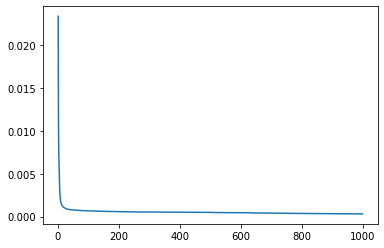

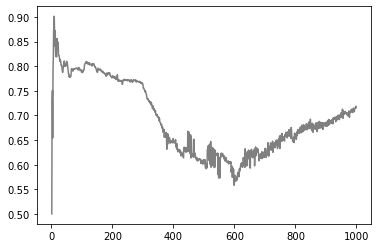

In [18]:
batch_size = 32
epochs = 1000
num_evals=100
mod = int(epochs / num_evals)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1).batch(batch_size)

loss_fn=tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

def nn_predict(x):
    x = (x - x_mean) / x_std
    beta = model(x) * y_std + y_mean
    return beta.numpy()
    
FVU = []
FVU_validation = []
SB_M1 = []

tf.random.set_seed(seed)

# Training step
for epoch in range(epochs):

    # Train the Network
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Record the loss computations
        with tf.GradientTape() as tape:
            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)
        # Compute and apply gradients
        model.grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(model.grads, model.trainable_weights))

    # Print the training loss for every tenth epoch
    if epoch % 10 == 0:
        print("\nEnd of epoch  " + str(epoch) + ", Training error " +
                      str(np.mean((y_train_eval - nn_predict(x_train_eval)) ** 2))) 
                      
    pred = nn_predict(x_train_eval)
    pred_validation = nn_predict(x_validation)
    FVU = np.append(FVU, FVU_fun(y_train, pred))
    FVU_validation = np.append(FVU_validation, FVU_fun(y_validation, pred_validation))
    
    p_tot, indices, s = Method_1_w0(x_test, y_test, px)
    pred_test = nn_predict(x_test)
    E_low_, E_high_, SB_ = Method_1(p_tot, indices, x_test, y_test, pred_test, px)
    SB_M1 = np.append(SB_M1, SB_)
    
t_vec = np.arange(0, epochs)
plt.plot(t_vec[1:], FVU_validation[1:])
plt.show()

plt.plot(t_vec[1:], SB_M1[1:], color='0.5', label="Method 1")
plt.show()